# DATA 558 Midterm

Will Wright

### Exercise 1

**Instructions**  
Compute the gradient $\nabla F(\beta)$ where the objective is:
$$\min_{\mathbf{\beta \in \mathbb{R}^d}} F(\beta):=\frac{1}{n}\sum_{i=1}^{n} \frac{1}{\rho}log(1+exp(-\rho y_ix_i^T\beta)) + \lambda\lVert\beta\rVert_2^2$$

**Solution**  
Start by moving the scalar $\frac{1}{\rho}$ outside the summation:  
$F(\beta)=\frac{1}{n\rho}\sum_{i=1}^{n} log(1+exp(-\rho y_ix_i^T\beta)) + \lambda\lVert\beta\rVert_2^2$

Next, break up into two terms:  
(1) $\frac{1}{n\rho}\sum_{i=1}^{n} log(1+exp(-\rho y_ix_i^T\beta))$  
(2) $\lambda\lVert \beta\rVert_2^2$ 

Find the derivative of the first term:  
(1) $\frac{\partial}{\partial \beta}\Big[\frac{1}{n\rho}\sum_{i=1}^{n} log(1+exp(-\rho y_ix_i^T\beta))\Big]$  
  
> Move the constant and summation to the outside of the derivative: 
$\frac{1}{n\rho}\sum_{i=1}^{n}\frac{\partial}{\partial \beta}\Big[ log(1+exp(-\rho y_ix_i^T\beta))\Big]$ 
  
> Use the chain rule with the following functions and their derivatives:  
$(f\circ g \circ h) = log(g\circ h)$  
$(f\circ g \circ h)' = \frac{1}{(g\circ h)} \cdot (g \circ h)' $  
$(g\circ h) = 1+exp(-h)$  
$(g\circ h)' = -exp(-h)\cdot h'$  
$h = \rho y_ix_i^T\beta$  
$h' = \rho y_ix_i$  
  
> Putting the chains together, we have:  
$(f\circ g \circ h)' = -\rho y_ix_i \cdot \frac{exp(- \rho y_ix_i^T\beta)}{1+exp(-\rho y_ix_i^T\beta)}$
  
> Re-apply constant scalar and summation:  
$=\frac{1}{n\rho}\sum_{i=1}^{n}-\rho y_ix_i \cdot \frac{exp(- \rho y_ix_i^T\beta)}{1+exp(-\rho y_ix_i^T\beta)}$

> Move the constant $-\rho$ outside the summation and cancel it out:
$=-\frac{1}{n}\sum_{i=1}^{n}y_ix_i \cdot \frac{exp(- \rho y_ix_i^T\beta)}{1+exp(-\rho y_ix_i^T\beta)}$

Next, derive the second term:  
(2) $\frac{\partial}{\partial \beta}\lambda\lVert \beta\rVert_2^2$  
  
> Move the constant $\lambda$ outside the derivation and convert to matrix form:  
$ =\lambda \frac{\partial}{\partial \beta}\beta^T \beta$
  
> Multiply by the identity matrix $I$:  
$ =\lambda \frac{\partial}{\partial \beta}\beta^T I \beta$
  
> Apply the property $\frac{\partial}{\partial x}x^T Ax = (A+A^T)x$:  
$ =\lambda (I + I^T)\beta$  
  
> Given that $(I + I^T)$ is simply a scalar of 2 for matrices, we can simplify:  

> $=2\lambda \beta $  
  
Next, we add (1) and (2) to get:  
$\nabla F(\beta) = -\frac{1}{n}\sum_{i=1}^{n}y_ix_i \cdot \frac{exp(- \rho y_ix_i^T\beta)}{1+exp(-\rho y_ix_i^T\beta)} + 2\lambda \beta$

**Instructions**  
Consider the Spam dataset from The Elements of Statistical Learning. Standardize the data, if you have not done so already. Be sure to use the training and test splits from the website.

In [1034]:
# Load Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.preprocessing
import scipy.linalg
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import copy
from random import sample
from random import choice
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sn

In [818]:
# Read data
spam = pd.read_table('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data', 
                   delim_whitespace=True, header = None)
test_indicator = pd.read_table('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.traintest',
                         delim_whitespace=True, header = None)

In [819]:
x = np.asarray(spam)[:, 0:-1]
y = np.asarray(spam)[:, -1]*2 - 1
test_indicator = np.array(test_indicator).T[0]

# Divide the data into train, test sets
x_train = x[test_indicator == 0, :]
x_test = x[test_indicator == 1, :]
y_train = y[test_indicator == 0]
y_test = y[test_indicator == 1]

# Standardize the data.
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Store feature size
d = np.size(x, 1)

**Instructions**  
Write a function _myrhologistic_ that implements the accelerated gradient algorithm to train the $\ell_2^2$-regularized binary logistic regression with $\rho$-logistic loss. The function takes as input
the initial step-size for the backtracking rule, the $\epsilon$ for the stopping criterion based on the norm of the gradient of the objective, and the value of $\rho$.

In [820]:
# Subroutines for myrhologistic to call:

# rho logistic gradient
def computegrad(beta, lamb, rho, x, y):
    yx = y[:, np.newaxis]*x
    denom = 1+np.exp(-rho*yx.dot(beta))
    grad = -1/len(y)*np.sum(yx*np.exp(-rho*yx.dot(beta[:, np.newaxis]))/
        denom[:, np.newaxis], axis=0) + 2*lamb*beta
    return grad

# rho logistic objective
def computeobj(beta, lamb, rho, x, y):
    return 1/len(y) * np.sum(1/rho*np.log(1 + np.exp(-rho*y*x.dot(beta)))) + lamb*np.linalg.norm(beta)**2

# backtracking with rho logistic
def backtracking(beta, lamb, rho, x, y, eta, alpha=0.5, gamma=0.8):
    grad_beta = computegrad(beta, lamb, rho, x, y)
    norm_grad_beta = np.linalg.norm(grad_beta)
    found_eta = False
    iter = 0
    while found_eta == False:
        if computeobj(beta - eta * grad_beta, lamb, rho, x, y) < \
            computeobj(beta, lamb, rho, x, y)- alpha * eta * norm_grad_beta ** 2:
                found_eta = True
        else:
            eta *= gamma
            iter += 1
    return eta

In [821]:
def computeEtaInit(x, y, lamb):
    eta_init = 1/(scipy.linalg.eigh(1/len(y)*x.T.dot(x),
                                eigvals=(d-1, d-1),
                                eigvals_only=True)[0]+lamb)
    return eta_init

In [822]:
def myrhologistic(x, y, beta_init, theta_init, lamb, rho, eta_init, eps):
    beta = beta_init
    theta = theta_init
    eta = eta_init
    grad_theta = computegrad(theta, lamb, rho, x, y)
    grad_beta = computegrad(beta, lamb, rho, x, y)
    beta_vals = beta
    theta_vals = theta
    iter = 0
    while np.linalg.norm(grad_beta) > eps:
        eta = backtracking(theta, lamb, rho, x, y, eta)
        beta_new = theta - eta*grad_theta
        theta = beta_new + iter/(iter+3)*(beta_new-beta)
        beta_vals = np.vstack((beta_vals, beta))
        theta_vals = np.vstack((theta_vals, theta))
        grad_theta = computegrad(theta, lamb, rho, x, y)
        grad_beta = computegrad(beta, lamb, rho, x, y)
        beta = beta_new
        iter += 1
    return beta_vals

**Instructions**  
Train your $\ell_2^2$-regularized binary logistic regression with $\rho$-logistic loss with $\rho=2$ and $\epsilon=10^{-3}$ o the Spam dataset for $\lambda=1$. Report your misclassification error for this value of $\lambda$.

In [823]:
# initialize parameters
rho = 2
eps = 10**-3
lamb = 1
beta_init = np.zeros(d)
theta_init = np.zeros(d)
eta_init = computeEtaInit(x_train, y_train, lamb)

In [824]:
train_betas = myrhologistic(x_train, y_train, beta_init, theta_init, lamb, rho, eta_init, eps)

In [825]:
beta_opt = train_betas[-1,:]

In [830]:
def compute_error(x, y, beta):
    y_pred = 1/(1+np.exp(-x.dot(beta))) > 0.5
    y_pred = y_pred*2 - 1 # Convert to +/- 1
    return np.mean(y_pred != y)

In [831]:
compute_error(x_train, y_train, beta_opt)

0.09526916802610114

**Instructions**  
Write a function _crossval_ that implements leave-one-out cross-validation and hold-out cross-validation. You may either write a function that implements each variant separately depending on the case, or write a general cross-validation function that can be instantiated in each case.

In [839]:
def loocv(x, y, lamb, rho, eps):
    n, d = x.shape
    beta_init = np.zeros(d)
    theta_init = np.zeros(d)
    errors = []
    for i in tqdm(range(n)):
        x_loo = np.vstack((x[0:i,:],x[(i+1):,:]))
        y_loo = np.concatenate([y[0:i],y[(i+1):]])
        eta_init = computeEtaInit(x_loo, y_loo, lamb)
        loo_betas = myrhologistic(x_loo, y_loo, beta_init, theta_init, lamb, rho, eta_init, eps)
        loo_beta_opt = loo_betas[-1,:]
        errors.append(compute_error(x_train, y_train, loo_beta_opt))
    return np.sum(errors)/n
    

In [834]:
def hocv(x, y, lamb, eps, rho, test_size = 0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size)
    d = x_train.shape[1]
    beta_init = np.zeros(d)
    theta_init = np.zeros(d)
    eta_init = computeEtaInit(x_train, y_train, lamb)
    ho_betas = myrhologistic(x_train, y_train, beta_init, theta_init, lamb, rho, eta_init, eps)
    ho_beta_opt = ho_betas[-1,:]
    error = compute_error(x_test, y_test, ho_beta_opt)
    return error

**Instructions**  
Find the optimal value of $\lambda$ using leave-one-out cross-validation.  Find the optimal value of $\lambda$ useing hold-out cross-validation with a 80%/20% split for the training set/testing set.  Report your misclassification errors for the two values of $\lambda$ found.

In [835]:
lamb_vals = []
for i in range(-3,3):
    lamb_vals.append(10**i) # testing very small to very large

In [836]:
def compute_lamb_opt(x, y, lamb_vals, eps, rho, method, test_size = 0.2):
    if method=='loocv':
        errors = []
        for lamb in lamb_vals:
            error = loocv(x, y, lamb, rho, eps)
            errors.append(error)
        minpos = errors.index(min(errors))
        lamb_opt = lamb_vals[minpos]
        return lamb_opt
    if method=='hocv':
        errors = []
        for lamb in lamb_vals:
            error = hocv(x, y, lamb, eps, rho, test_size)
            errors.append(error)
        minpos = errors.index(min(errors))
        lamb_opt = lamb_vals[minpos]
        return lamb_opt
    else:
        print('Unknown method')

In [840]:
loocv_lamb_opt = compute_lamb_opt(x_train, y_train, lamb_vals, eps, rho, method = 'loocv')
loocv_error = loocv(x_train, y_train, loocv_lamb_opt, rho, eps)
print('Leave-one-out optimal lambda is: ',loocv_lamb_opt)
print('Leave-one-out misclassification rate: ',loocv_error)

100%|██████████| 3065/3065 [20:36<00:00,  2.54it/s]

Leave-one-out optimal lambda is:  0.001
Leave-one-out misclassification rate:  0.07898842107784303


In [837]:
hocv_lamb_opt = compute_lamb_opt(x_train, y_train, lamb_vals, eps, rho, method = 'hocv')
hocv_error = hocv(x_train, y_train, hocv_lamb_opt, eps, rho, test_size = 0.2)
print('80/20 Hold-out optimal lambda is: ',hocv_lamb_opt)
print('80/20 Hold-out misclassification rate: ',hocv_error)


80/20 Hold-out optimal lambda is:  0.001
80/20 Hold-out misclassification rate:  0.0864600326264274


# Exercise 2 - Data Competition Project

**Instructions**  
Pick two classes of your choice from the dataset. Train a classifier using $\ell_2^2$-regularized binary
logistic regression with $\rho$-logistic loss on the training set using your own accelerated gradient algorithm with $\rho = 2$, $\epsilon = 10^{−3}$, and $\lambda = 1$. Be sure to use the features you previously generated with the provided script rather than the raw image features. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.

In [898]:
# Load data (if on Windows)
# x_train = np.load('C:/Users/Will/Documents/data_competition1_files/train_features.npy')
# y_train = np.load('C:/Users/Will/Documents/data_competition1_files/train_labels.npy')
# x_val = np.load('C:/Users/Will/Documents/data_competition1_files/val_features.npy')
# y_val = np.load('C:/Users/Will/Documents/data_competition1_files/val_labels.npy')

# Load data (if on Mac)
x_train_raw = np.load('/Users/willwright/Downloads/data_competition1_files/train_features.npy')
y_train_raw = np.load('/Users/willwright/Downloads/data_competition1_files/train_labels.npy')
x_val_raw = np.load('/Users/willwright/Downloads/data_competition1_files/val_features.npy')
y_val_raw = np.load('/Users/willwright/Downloads/data_competition1_files/val_labels.npy')

In [867]:
# Subset of data (selecting group 5 and 9)
class1 = 5
class2 = 9
train_ids = np.array([np.where(y_train_raw==class1),np.where(y_train_raw==class2)]).reshape(-1)
x_train = x_train_raw.copy()[train_ids]
y_train = y_train_raw.copy()[train_ids]
val_ids = np.array([np.where(y_val_raw==class1),np.where(y_val_raw==class2)]).reshape(-1)
x_val = x_val_raw.copy()[val_ids]
y_val = y_val_raw.copy()[val_ids]

In [868]:
# change indicators from the original classes to +1/-1
y_train[y_train==class1] = 1
y_train[y_train==class2] = -1
y_val[y_val==class1] = 1
y_val[y_val==class2] = -1

In [869]:
# Standardize
x_standardizer = preprocessing.StandardScaler()
x_train = x_standardizer.fit_transform(x_train)
x_val = x_standardizer.fit_transform(x_val)

In [846]:
# Initialize parameters
n, d = x_train.shape
rho = 2
eps = 10**-3
lamb = 1
beta_init = np.zeros(d)
theta_init = np.zeros(d)
eta_init = computeEtaInit(x_train, y_train, lamb)

In [847]:
# Train Model
kaggle_betas = myrhologistic(x_train, y_train, beta_init, theta_init, lamb, rho, eta_init, eps)

In [497]:
def plot_misclassification_errors(x_train, y_train, x_val, y_val, betas):
    iterations = betas.shape[0]
    train_errors = []
    val_errors = []
    for i in range(iterations):
        train_error = compute_error(x_train, y_train, betas[i,:])
        train_errors.append(train_error)
        val_error = compute_error(x_val, y_val, betas[i,:])
        val_errors.append(val_error)
    plt.plot(train_errors, color = "blue")
    plt.plot(val_errors, color = "red")
    plt.ylabel("Misclassification Rate")
    plt.xlabel("Iterations")
    plt.title("Misclassification Rates by Iteration")
    plt.legend(["Training Data", "Validation Data"])
    plt.show()

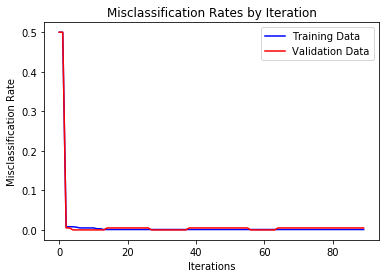

In [848]:
# Plot misclassification error on the training set by iteration
plot_misclassification_errors(x_train, y_train, x_val, y_val, kaggle_betas)

In [849]:
print('Training Misclassificaiton Rate: ',compute_error(x_train, y_train, kaggle_betas[-1,:]))
print('Validation Misclassificaiton Rate: ',compute_error(x_val, y_val, kaggle_betas[-1,:]))

Training Misclassificaiton Rate:  0.001
Validation Misclassificaiton Rate:  0.005


**Instructions**  
Find the value of the regularization parameter $\lambda$ using using leave-one-out cross-validation. Find the value of the regularization parameter $\lambda$ using using hold-out cross-validation. Train a classifier using $\ell_2^2$-regularized binary logistic regression with $\rho$-logistic loss on the training set using your own accelerated gradient algorithm with that value of $\lambda$ found by hold-out cross-validation. Plot, with different colors, the misclassification error on the training set and on the validation set vs. iterations.

#### LOOCV

In [850]:
loocv_lamb_opt = compute_lamb_opt(x_train, y_train, lamb_vals, eps, rho, method = 'loocv')
loocv_error = loocv(x_train, y_train, loocv_lamb_opt, rho, eps)
print('Leave-one-out optimal lambda is: ',loocv_lamb_opt)
print('Leave-one-out misclassification rate: ',loocv_error)

 16%|█▌        | 162/1000 [59:37<5:14:29, 22.52s/it]

KeyboardInterrupt: 

This is taking multiple days to run so I'm going to take a sub-sample:

In [876]:
sample_train_index = sample(list(range(len(x_train))),50)
x_train_sample = x_train.copy()[sample_train_index]
y_train_sample = y_train.copy()[sample_train_index]
sample_val_index = sample(list(range(len(x_val))),50)
x_val_sample = x_val.copy()[sample_val_index]
y_val_sample = y_val.copy()[sample_val_index]

In [878]:
loocv_lamb_opt = compute_lamb_opt(x_train_sample, y_train_sample, lamb_vals, eps, rho, method = 'loocv')
loocv_error = loocv(x_train_sample, y_train_sample, loocv_lamb_opt, rho, eps)
print('Leave-one-out optimal lambda is: ',loocv_lamb_opt)
print('Leave-one-out misclassification rate: ',loocv_error)


100%|██████████| 50/50 [03:33<00:00,  4.17s/it]

100%|██████████| 50/50 [02:59<00:00,  3.59s/it]

100%|██████████| 50/50 [03:14<00:00,  3.80s/it]

 14%|█▍        | 7/50 [00:25<02:36,  3.65s/it]


100%|██████████| 50/50 [03:03<00:00,  3.68s/it]

100%|██████████| 50/50 [02:43<00:00,  3.27s/it]

100%|██████████| 50/50 [02:40<00:00,  3.37s/it]

 30%|███       | 15/50 [00:51<01:52,  3.21s/it]


100%|██████████| 50/50 [02:40<00:00,  3.17s/it]


Leave-one-out optimal lambda is:  100
Leave-one-out misclassification rate:  0.01582


In [881]:
# Train model with ideal lambda, as computed by LOOCV
loocv_lamb_opt_betas = myrhologistic(x_train_sample, y_train_sample, 
                                     beta_init, theta_init, loocv_lamb_opt, rho, eta_init, eps)

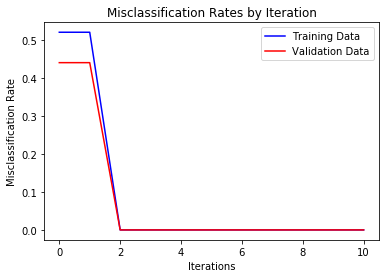

In [882]:
plot_misclassification_errors(x_train_sample, y_train_sample, x_val_sample, y_val_sample, loocv_lamb_opt_betas)

This could be due to the sub-sampling, but it's certainly suspicious. Why would there be no change until the 3rd iteration when it snaps perfectly to 0%??

In [883]:
print('Training Misclassificaiton Rate: ',compute_error(x_train_sample, y_train_sample, loocv_lamb_opt_betas[-1,:]))
print('Validation Misclassificaiton Rate: ',compute_error(x_val_sample, y_val_sample, loocv_lamb_opt_betas[-1,:]))

Training Misclassificaiton Rate:  0.0
Validation Misclassificaiton Rate:  0.0


#### HOCV

In [851]:
hocv_lamb_opt = compute_lamb_opt(x_train, y_train, lamb_vals, eps, rho, method = 'hocv')
hocv_error = hocv(x_train, y_train, hocv_lamb_opt, eps, rho, test_size = 0.2)
print('80/20 Hold-out optimal lambda is: ',hocv_lamb_opt)
print('80/20 Hold-out misclassification rate: ',hocv_error)

80/20 Hold-out optimal lambda is:  0.001
80/20 Hold-out misclassification rate:  0.0


In [852]:
# Train model with ideal lambda, as computed by HOCV
hocv_lamb_opt_betas = myrhologistic(x_train, y_train, beta_init, theta_init, hocv_lamb_opt, rho, eta_init, eps)

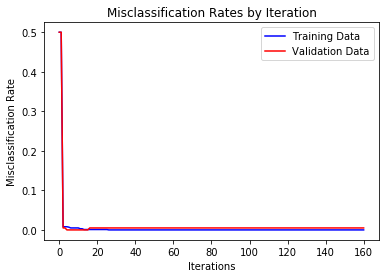

In [853]:
plot_misclassification_errors(x_train, y_train, x_val, y_val, hocv_lamb_opt_betas)

In [854]:
print('Training Misclassificaiton Rate: ',compute_error(x_train, y_train, hocv_lamb_opt_betas[-1,:]))
print('Validation Misclassificaiton Rate: ',compute_error(x_val, y_val, hocv_lamb_opt_betas[-1,:]))

Training Misclassificaiton Rate:  0.0
Validation Misclassificaiton Rate:  0.005


This is an _obscenely_ good misclassification rate. Too good, perhaps.

**Instructions**  
Consider all pairs of classes from the dataset. For each pair of classes, train a classifier using
a $\ell_2^2$-regularized binary logistic regression with $\rho$-logistic loss on the training set comprising
only the data-points for that pair of classes using your own fast gradient algorithm. For each
pair of classes, find the value of the regularization parameter $\lambda$ using hold-out cross-validation
on the training set comprising only the data-points for that pair of classes.

In [855]:
class_possibilities = np.unique(y_train_raw)

In [856]:
# create array of all possible pairs
all_pairs = np.empty((0,2),int)
for i in class_possibilities:
    for j in class_possibilities:
        all_pairs = np.append(all_pairs, 
                              np.array([class_possibilities[i],class_possibilities[j]]).reshape(1,2), 
                              axis = 0)

In [857]:
keep_index = []
for i in range(len(all_pairs)):
    # remove pairs with same class
    if all_pairs[i,0] != all_pairs[i,1]:
        # remove pairs already in the array higher up, but in different order
        if any(([all_pairs[i,1],all_pairs[i,0]] == x).all() for x in list(all_pairs[0:i-1]))==False:
            keep_index.append(i) 

In [858]:
all_pairs = all_pairs[keep_index]

In [788]:
lambdas_opt = []
models = []
for i in tqdm(range(len(all_pairs))):
    # Subset to pair
    class1, class2 = all_pairs[i]
    train_ids = np.array([np.where(y_train_raw==class1),np.where(y_train_raw==class2)]).reshape(-1)
    x_train = x_train_raw[train_ids]
    y_train = y_train_raw[train_ids]
    val_ids = np.array([np.where(y_val_raw==class1),np.where(y_val_raw==class2)]).reshape(-1)
    x_val = x_val_raw[val_ids]
    y_val = y_val_raw[val_ids]
    # Replace class indicators with +/-1; make sure to set -1 to avoid converting all values to 1 (if the class2 is 1)
    y_train[y_train==class2] = -1
    y_train[y_train==class1] = 1
    y_val[y_val==class2] = -1
    y_val[y_val==class1] = 1
    # Standardize
    x_standardizer = preprocessing.StandardScaler()
    x_train = x_standardizer.fit_transform(x_train)
    x_val = x_standardizer.fit_transform(x_val)
    # Calculate optimal lambda
    hocv_lamb_opt = compute_lamb_opt(x_train, y_train, lamb_vals, eps, rho, method = 'hocv')
    lambdas_opt.append(hocv_lamb_opt)
    # train model with optimal lambda
    betas = myrhologistic(x_train, 
                          y_train, 
                          beta_init, 
                          theta_init, 
                          lambdas_opt[i], 
                          rho, 
                          computeEtaInit(x_train, y_train, lambdas_opt[i]), 
                          eps)
    betas_opt = betas[-1]
    models.append(betas_opt)

**Instructions**  
Write a function that for any new data point predicts its label. To do this, you will perform the following: input the data point into each classifier (for each pair of classes) you trained above. Record the class predicted by each classifier. Then your prediction for this data point is the most frequently predicted class. If there is a tie, randomly choose between the tied classes. Report the misclassification error on the validation set and test set. Report the precision/recall on the validation set.


In [884]:
def compute_prediction(x, y, beta):
    y_pred = 1/(1+np.exp(-x.dot(beta))) > 0.5 
    y_pred = y_pred*2 - 1 # Convert to +/- 1
    return y_pred

In [910]:
# Set train/validation to total dataset
x_train = x_train_raw.copy()
y_train = y_train_raw.copy()
x_val = x_val_raw.copy()
y_val = y_val_raw.copy()

# Standardize
x_standardizer = preprocessing.StandardScaler()
x_train = x_standardizer.fit_transform(x_train)
x_val = x_standardizer.fit_transform(x_val)

#### Training set predictions and results

In [1015]:
train_predictions = np.zeros((len(y_train),len(models)))

In [1016]:
for i in range(len(y_train)):
    for j in range(len(models)):
        train_predictions[i,j] = compute_prediction(x_train[i], y_train[i], models[j])

In [1017]:
# convert from +/-1 to the original class 
for i in range(train_predictions.shape[0]):
    for j in range(train_predictions.shape[1]):
        if train_predictions[i,j]==1:
            train_predictions[i,j]=all_pairs[j,0]
        else:
            train_predictions[i,j]=all_pairs[j,1]

In [1018]:
def countX(lst, x): 
    return lst.count(x) 

In [1020]:
# for each data point, pick either the most occurring prediction by all the classifiers or, if tie, random between
# the tied classes
train_prediction_results = []
for i in range(len(train_predictions)):
    freq = []
    for j in class_possibilities:
        freq.append(countX(list(train_predictions[i]),class_possibilities[j]))
    prediction = class_possibilities[choice([k for k,x in enumerate(freq) if x==max(freq)])]
    train_prediction_results.append(prediction)

In [1021]:
freq = []
for i in class_possibilities:
    freq.append(countX(train_prediction_results,class_possibilities[i]))

In [1022]:
# show results
pd.DataFrame({'Class': class_possibilities, 'Freq': freq})

,class_indicator,freq
0,0,549
1,1,460
2,2,500
3,3,389
4,4,472
5,5,539
6,6,566
7,7,460
8,8,527
9,9,538


In [1023]:
# misclassification on the test set
print('Training Misclassificaiton Rate: ',np.mean(train_prediction_results != y_train))

Training Misclassificaiton Rate:  0.0664


In [1042]:
train_conf_matrix = confusion_matrix(y_train, train_prediction_results)

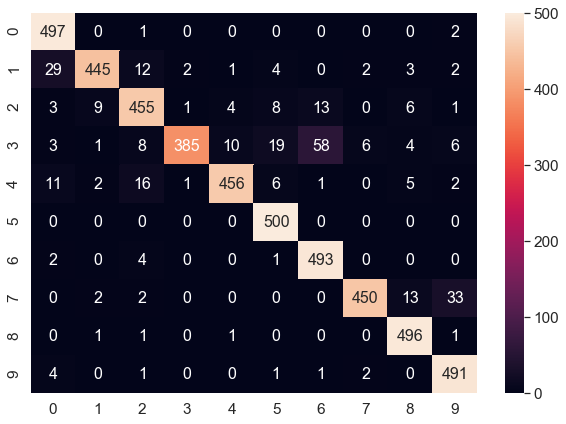

In [1047]:
array = train_conf_matrix
df_cm = pd.DataFrame(array, index = class_possibilities,
                  columns = class_possibilities)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt = 'g')# font size

In [1048]:
precision, recall, fscore, support = precision_recall_fscore_support(y_train, train_prediction_results)

In [1051]:
pd.DataFrame({'Class': class_possibilities,
             'Training Pecision': precision,
             'Training Recall': recall,})

,Class,Training Pecision,Training Recall
0,0,0.905282,0.994
1,1,0.967391,0.890
2,2,0.910000,0.910
3,3,0.989717,0.770
4,4,0.966102,0.912
5,5,0.927644,1.000
6,6,0.871025,0.986
7,7,0.978261,0.900
8,8,0.941176,0.992
9,9,0.912639,0.982


#### Test set predictions and results

In [1024]:
val_predictions = np.zeros((len(y_val),len(models)))
for i in range(len(y_val)):
    for j in range(len(models)):
        val_predictions[i,j] = compute_prediction(x_val[i], y_val[i], models[j])
        
# convert from +/-1 to the original class 
for i in range(val_predictions.shape[0]):
    for j in range(val_predictions.shape[1]):
        if val_predictions[i,j]==1:
            val_predictions[i,j]=all_pairs[j,0]
        else:
            val_predictions[i,j]=all_pairs[j,1]
            
# for each data point, pick either the most occurring prediction by all the classifiers or, if tie, random between
# the tied classes
val_prediction_results = []
for i in range(len(val_predictions)):
    freq = []
    for j in class_possibilities:
        freq.append(countX(list(val_predictions[i]),class_possibilities[j]))
    prediction = class_possibilities[choice([k for k,x in enumerate(freq) if x==max(freq)])]
    val_prediction_results.append(prediction)
    
freq = []
for i in class_possibilities:
    freq.append(countX(val_prediction_results,class_possibilities[i]))
    
# show results
pd.DataFrame({'Class Indicator': class_possibilities, 'Freq': freq})

,class_indicator,freq
0,0,139
1,1,74
2,2,101
3,3,56
4,4,80
5,5,124
6,6,108
7,7,77
8,8,133
9,9,108


In [1027]:
# misclassification on the test set
print('Test Misclassificaiton Rate: ',np.mean(val_prediction_results != y_val))

Test Misclassificaiton Rate:  0.256


In [1052]:
val_conf_matrix = confusion_matrix(y_val, val_prediction_results)

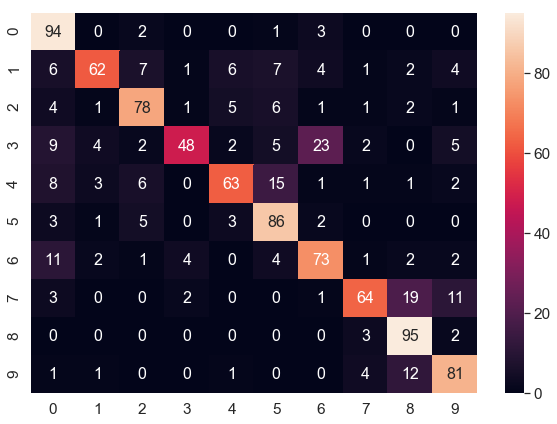

In [1053]:
array = val_conf_matrix
df_cm = pd.DataFrame(array, index = class_possibilities,
                  columns = class_possibilities)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt = 'g')# font size

In [1054]:
precision, recall, fscore, support = precision_recall_fscore_support(y_val, val_prediction_results)

In [1055]:
pd.DataFrame({'Class': class_possibilities,
             'Training Pecision': precision,
             'Training Recall': recall,})

,Class,Training Pecision,Training Recall
0,0,0.676259,0.94
1,1,0.837838,0.62
2,2,0.772277,0.78
3,3,0.857143,0.48
4,4,0.787500,0.63
5,5,0.693548,0.86
6,6,0.675926,0.73
7,7,0.831169,0.64
8,8,0.714286,0.95
9,9,0.750000,0.81
